## Задача 2 - Моделирование водонасыщенности ##

Новиков Евгений 120м

Импорт

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from scipy.optimize import minimize
import seaborn as sns
from scipy import interpolate
from scipy.misc import derivative

In [2]:
sns.set_style("darkgrid") # тема для красоты

Чтение файла

In [3]:
raw_file = pd.read_csv('ККД.csv', sep = ';', encoding='cp1251')
# ККД - тот же самый файл, только переведенный в .csv

In [4]:
raw_file

,Скважина,Стратиграфическая единица,Лабораторный номер образца,Метод исследования,"Интервал отбора, м",Unnamed: 5,"Место взятия, м",Литологическое описание,"Пористость, %","Проницаемость, мД","Водонасыщенность, %","Капиллярное давление, МПа"
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,кровля,подошва,NaN,NaN,NaN,NaN,NaN,NaN
2,6747бис,ВК3,33874-07,Полупроницаемой мембраны,1574,1581,0.66,Алевролит мелкозернистый глинистый,23.4,9.2,100.0,0.0027
3,6747бис,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.0057
4,6747бис,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.0100
...,...,...,...,...,...,...,...,...,...,...,...,...
152,6747бис,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.8,0.1000
153,6747бис,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.6,0.2000
154,6747бис,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.7,0.4000
155,6747бис,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.8,0.7000


Парсинг

In [5]:
raw_file.drop(raw_file[raw_file['Капиллярное давление, МПа'].isna()].index, inplace = True)
raw_file.fillna(method='ffill', inplace=True) # заполнение всех Nan
probes = raw_file['Лабораторный номер образца'].unique() # разделение замеров по уникальным лабораторным номерам

Необходимые для работы в дальнейшем функции

In [6]:
def show_(index): # функция для более корокого обращения к образцу, в дальнейшем будет активно применяться
    return raw_file[(raw_file['Лабораторный номер образца'] == index)]

Swi = show_(probes[0])['Водонасыщенность, %'].min() # определение Swi
Pc = show_(probes[0])['Капиллярное давление, МПа'] # присвоение Pc

def d_sw(p, Sw ): # 2-рая производная
    return (np.diff ( np.diff(Sw(p) ) / np.diff(p) )) / np.diff ( p  ) [:-1]

In [7]:
def fun(x): # функция Брукса-Кори для последующей оптимизации
    n = x # подается степень, возвращается Х
    res = np.array([Swi + (1 + Swi) * (Pd/Pc)**(1/n)]).reshape(X_norm.shape)
    for i in range(len(res)): 
        if (res[i] > 1): # введение ограничения на максимальную водонасыщенность
            res[i] = 1
    return res


def fun_loss(x): # функционал невязки для оптимизации степени - для определения коэффициента кривизны капиллярных кривых
    n = x # подается степень, возвращается ошибка
    Sw = fun(n)
    return np.sum((X_norm - Sw).reshape(X_norm.shape[0])**2)

initial_guess = [1] # начальное значение для метода optimize.minimaze()

In [8]:
def fun_for_check(x):
    Swi,Pd,Pc,n = x
    mas = []
    res = 0
    for i in range(len(Pc)): 
        res = Swi + (1 + Swi) * (Pd/Pc[i])**(1/n)
        if (res > 1):
            res = 1
        mas.append(res)
    return mas

In [9]:
result = [] # сюда будут записываться 
XY_par = []

for i in range(len(probes)): # проход по всем образцам
    Swi = show_(probes[i])['Водонасыщенность, %'].min()
    Swi = Swi/100 # приведение к (0,1)
    Pc = show_(probes[i])['Капиллярное давление, МПа']
    
    X = np.array((show_(probes[i])['Водонасыщенность, %'])).reshape(-1) # Питон лучше кушает массивы, приведенные к такой форме
    X_norm = X / 100 # приведение к (0,1)
    Y = np.array(show_(probes[i])['Капиллярное давление, МПа']).reshape(-1)
    
    p_smooth = np.linspace(np.log10(Y.min()), np.log10(Y.max()), 20) # сетка давлений
    # для взятия 2-рой производной необходима непрерывная фукнция
    sw_smooth = interpolate.PchipInterpolator(np.log10(Y),  X_norm) # интерполяция для непрерывности
    
    abs_d = np.abs(d_sw(p_smooth, sw_smooth)) # берем вторую производную по заранее написанной функции
    
    for i in range(2): 
        cond = np.where(abs_d == abs_d.max())[0][0] # ввод условия
        cond_on_sw = cond + 1 # индекс + 1, т.к. с нуля
        val = sw_smooth(p_smooth)[cond_on_sw] # возьмем Sw в точке Pd
        if val < 90: # убираем значения sw меньше 90
            np.delete(abs_d, cond)
        else:
            break
    
    Abs_m90 = np.abs(X_norm - val) # массив значений при Sw > 90
    Pd_i = np.where(Abs_m90 == Abs_m90.min())[0][0] # получаем индекс для Pd
    Pd = Y[Pd_i]
    
    if (Pd >= 0.2): # в случае, если наблюдаемая производная не дает хороший результат для Pd, оптимальным средним значением будет 0.1
        Pd = 0.01 
    
    min_r = minimize(fun_loss, initial_guess) # минимизация функционала невязки с целью определения кривизны капиллярных кривых
    result.append([Swi,Pd,list(Pc),min_r.x[0]]) # запись [Swi,Pd,Pc,n]
    XY_par.append([X_norm, Y]) # запись для удобной дальнейшей визуализации ['Водонасыщенность, %', 'Капиллярное давление, МПа']
    
    


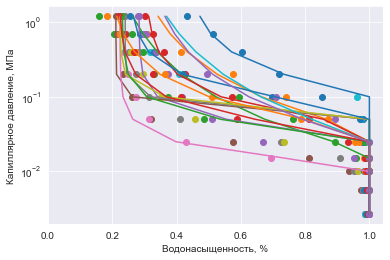

In [10]:
for i in range(len(probes)): # общая проверка решений
    plt.semilogy(fun_for_check(result[i]),result[i][2])
    plt.scatter(XY_par[i][0] , XY_par[i][1])
    plt.xlabel('Водонасыщенность, %')
    plt.ylabel('Капиллярное давление, МПа')
    plt.xticks(np.arange(0,1.1,0.2))

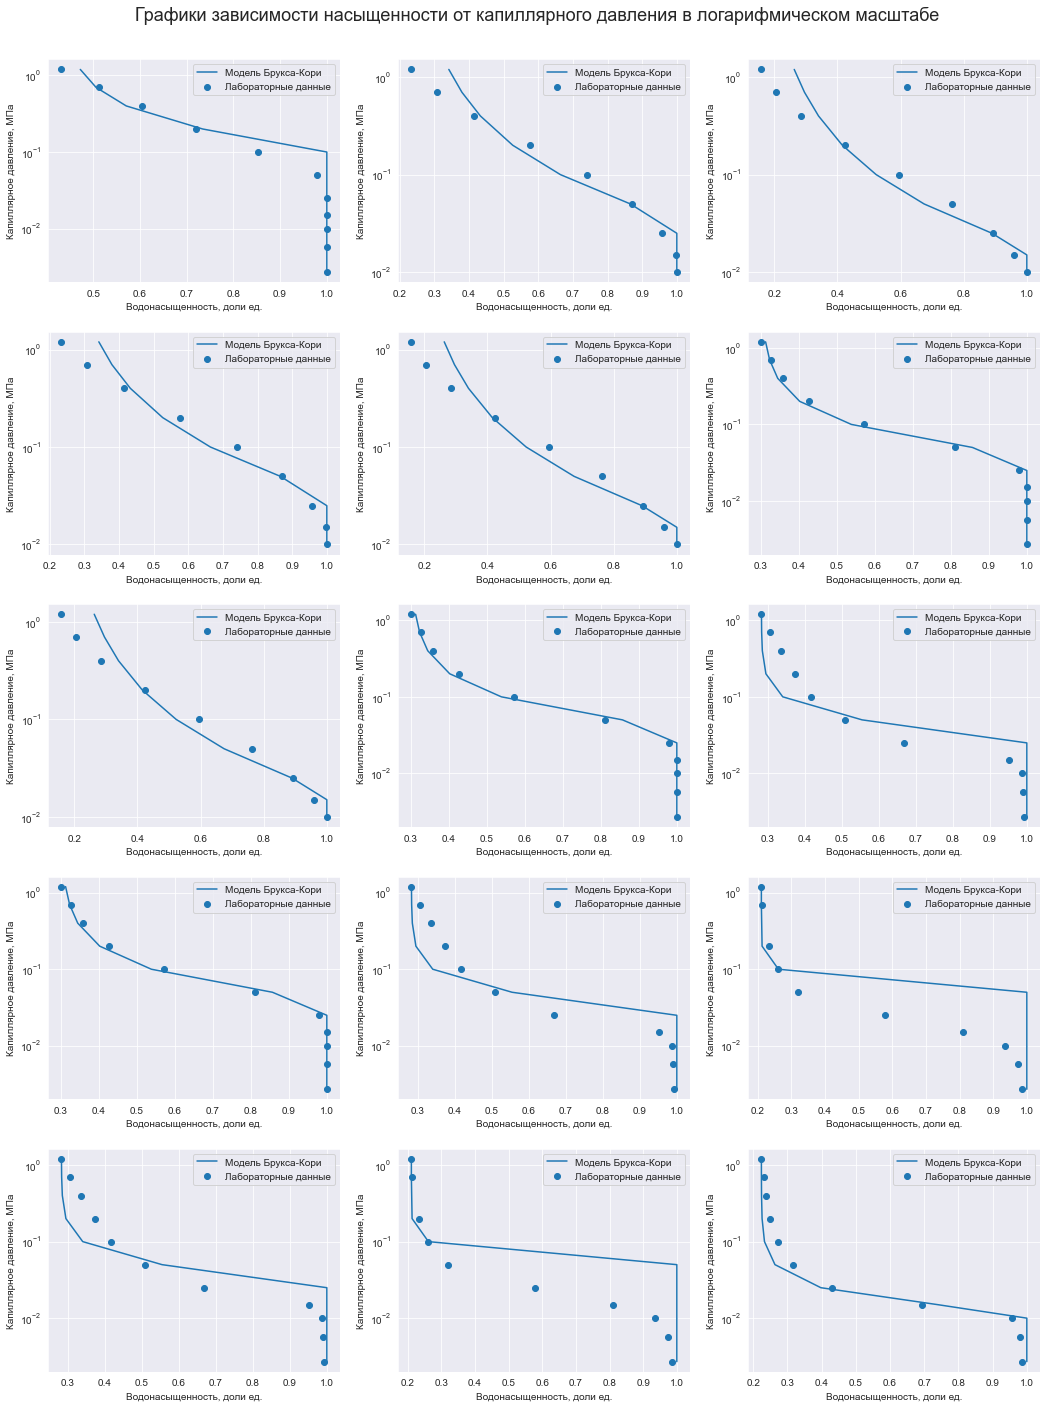

In [11]:
fig, ax = plt.subplots(5, 3, figsize=(15,20))
fig.suptitle('Графики зависимости насыщенности от капиллярного давления в логарифмическом масштабе', fontsize = 18)
fig.tight_layout(pad=3.0)

for k in range(5):
    for i in range(3):
        ax[k][i].semilogy(fun_for_check(result[i+k]),result[i+k][2], label = 'Модель Брукса-Кори' )
        ax[k][i].scatter(XY_par[i+k][0] , XY_par[i+k][1], label = 'Лабораторные данные')
        ax[k][i].set_xlabel('Водонасыщенность, доли ед.')
        ax[k][i].set_ylabel('Капиллярное давление, МПа')
        ax[k][i].legend()

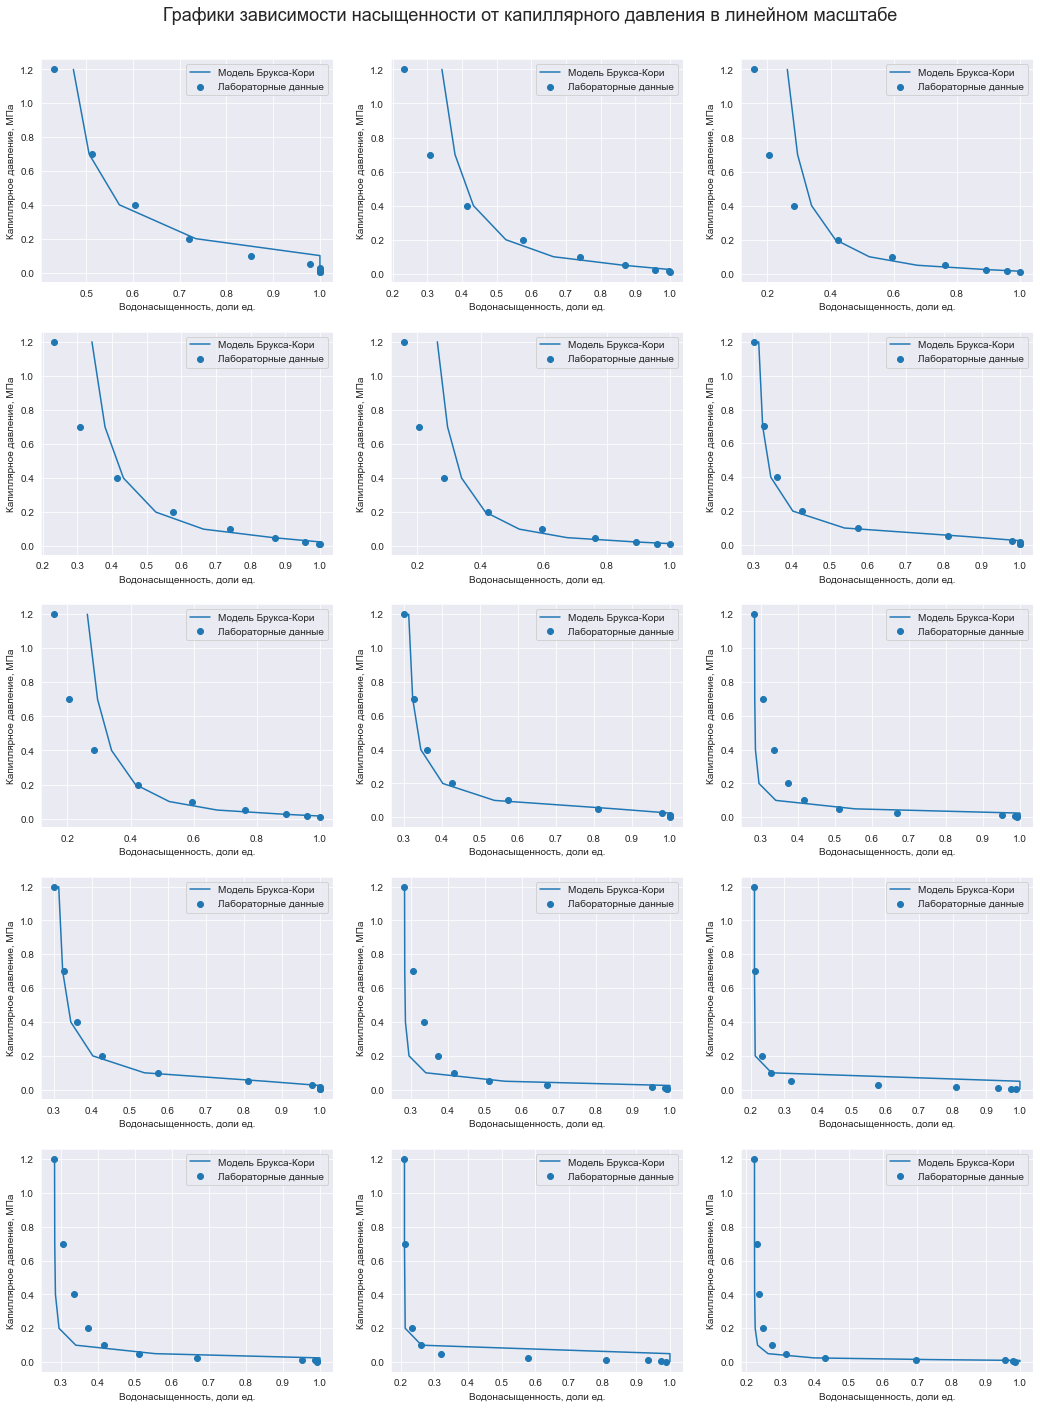

In [12]:
fig, ax = plt.subplots(5, 3, figsize=(15,20))
fig.suptitle('Графики зависимости насыщенности от капиллярного давления в линейном масштабе', fontsize = 18)
fig.tight_layout(pad=3.0)

for k in range(5):
    for i in range(3):
        ax[k][i].plot(fun_for_check(result[i+k]),result[i+k][2], label = 'Модель Брукса-Кори' )
        ax[k][i].scatter(XY_par[i+k][0] , XY_par[i+k][1], label = 'Лабораторные данные')
        ax[k][i].set_xlabel('Водонасыщенность, доли ед.')
        ax[k][i].set_ylabel('Капиллярное давление, МПа')
        #ax[k][i].set_ylim(0,0.2)
        ax[k][i].legend()

Вывод - некоторые образцы хорошо аппроксимируются моделью Брукса-Кори, а некоторые так себе, но методически вроде смог соблюсти правильность выполнения задачи.